# Load Libraries

In [1]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [1]:
library(DBI)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Connect to DB, load data, clean data

In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [12]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
all_patches <- dbGetQuery(con, "
    SELECT 
        p.package_id, 
        p.from_id, 
        p.to_id, 
        (p.from_semver).major AS from_semver_major, 
        (p.from_semver).minor AS from_semver_minor, 
        (p.from_semver).bug AS from_semver_bug,
        (p.to_semver).major AS to_semver_major, 
        (p.to_semver).minor AS to_semver_minor, 
        (p.to_semver).bug AS to_semver_bug,
        p.from_created,
        p.to_created,
        p.ty,
        p.patched_ghsa,
        adv.severity,
        adv.description,
        adv.summary,
        adv.published_at,
        adv.updated_at,
        adv.cvss_score,
        adv.cvss_vector,
        EXTRACT(EPOCH FROM (p.to_created - adv.published_at)) AS time_to_patch
    FROM analysis.vuln_patch_updates p
    INNER JOIN ghsa adv
    ON p.patched_ghsa = adv.id
")

In [13]:
all_patches$ty <- sapply(all_patches$ty, as.character)

In [14]:
head(all_patches)

,package_id,from_id,to_id,from_semver_major,from_semver_minor,from_semver_bug,to_semver_major,to_semver_minor,to_semver_bug,from_created,⋯,ty,patched_ghsa,severity,description,summary,published_at,updated_at,cvss_score,cvss_vector,time_to_patch
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<dttm>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dttm>,<dbl>,<chr>,<dbl>
1,2228162,17731713,17731714,0,6,1,0,6,2,2020-09-24 14:09:31,⋯,bug,GHSA-6xrf-q977-5vgc,MODERATE,"A vulnerability, which was classified as critical, has been found in json-pointer. Affected by this issue is the function set of the file index.js. The manipulation leads to improperly controlled modification of object prototype attributes ('prototype pollution'). The attack may be launched remotely. The name of the patch is 859c9984b6c407fc2d5a0a7e47c7274daa681941. It is recommended to apply a patch to fix this issue. VDB-216794 is the identifier assigned to this vulnerability.",json-pointer vulnerable to Prototype Pollution,2022-12-26 09:30:25,2022-12-30 17:21:12,NA,NA,-26937233
2,2137896,16908340,16908341,5,0,0,5,0,1,2019-10-22 05:18:23,⋯,bug,GHSA-2j2x-2gpw-g8fm,MODERATE,"flat helps flatten/unflatten nested Javascript objects. A vulnerability, which was classified as critical, was found in hughsk flat up to 5.0.0. This affects the function unflatten of the file index.js. The manipulation leads to improperly controlled modification of object prototype attributes ('prototype pollution'). It is possible to initiate the attack remotely. Upgrading to version 5.0.1 can address this issue. The name of the patch is 20ef0ef55dfa028caddaedbcb33efbdb04d18e13. It is recommended to upgrade the affected component. The identifier VDB-216777 was assigned to this vulnerability.",flat vulnerable to Prototype Pollution,2022-12-25 21:30:22,2022-12-30 16:27:14,NA,NA,-75276734
3,2266143,18213532,18213533,2,2,1,3,0,0,2014-12-29 14:38:37,⋯,major,GHSA-j5p7-jf4q-742q,LOW,A vulnerability was found in markdown-it up to 2.x. It has been classified as problematic. Affected is an unknown function of the file `lib/common/html_re.js`. The manipulation leads to inefficient regular expression complexity. Upgrading to version 3.0.0 is able to address this issue. The name of the patch is 89c8620157d6e38f9872811620d25138fc9d1b0d. It is recommended to upgrade the affected component. The identifier of this vulnerability is VDB-216852.,markdown-it vulnerable to Inefficient Regular Expression Complexity,2022-12-27 09:30:41,2022-12-30 16:27:09,NA,NA,-251756021
4,2313525,18808345,18808346,1,1,1,1,2,0,2016-10-20 05:03:22,⋯,minor,GHSA-79mp-cxp4-9p6r,MODERATE,Json2html is a client side javascript HTML templating library with wrappers for both jQuery and Node.js. A vulnerability was found in moappi Json2html up to 1.1.x and classified as problematic. This issue affects some unknown processing of the file json2html.js. The manipulation leads to cross site scripting. The attack may be initiated remotely. Upgrading to version 1.2.0 can address this issue. The name of the patch is 2d3d24d971b19a8ed1fb823596300b9835d55801. The associated identifier of this vulnerability is VDB-216959.,Json2html vulnerable to cross-site scripting,2022-12-28 12:30:50,2022-12-28 20:35:03,5.6,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:L/I:L/A:L,-154020580
5,1904602,14220782,27431397,3,9,9,3,9,10,2022-02-24 21:26:12,⋯,bug,GHSA-4w2j-2rg4-5mjw,CRITICAL,The package vm2 before 3.9.10 is vulnerable to Arbitrary Code Execution due to the usage of prototype lookup for the WeakMap.prototype.set method. Exploiting this vulnerability leads to access to a host object and a sandbox compromise.,vm2 vulnerable to Arbitrary Code Execution,2022-12-21 06:30:29,2022-12-22 03:33:45,9.8,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,-14579313
6,1769282,12723028,26961568,1,36,0,1,36,1,2021-12-07 10:49:13,⋯,bug,GHSA-g662-qq45-ppwm,MODERATE,The package smoothie from 1.31.0 and before 1.36.1 are vulnerable to Cross-site Scripting (XSS) due to improper use

## Histogram of publish-to-patch time

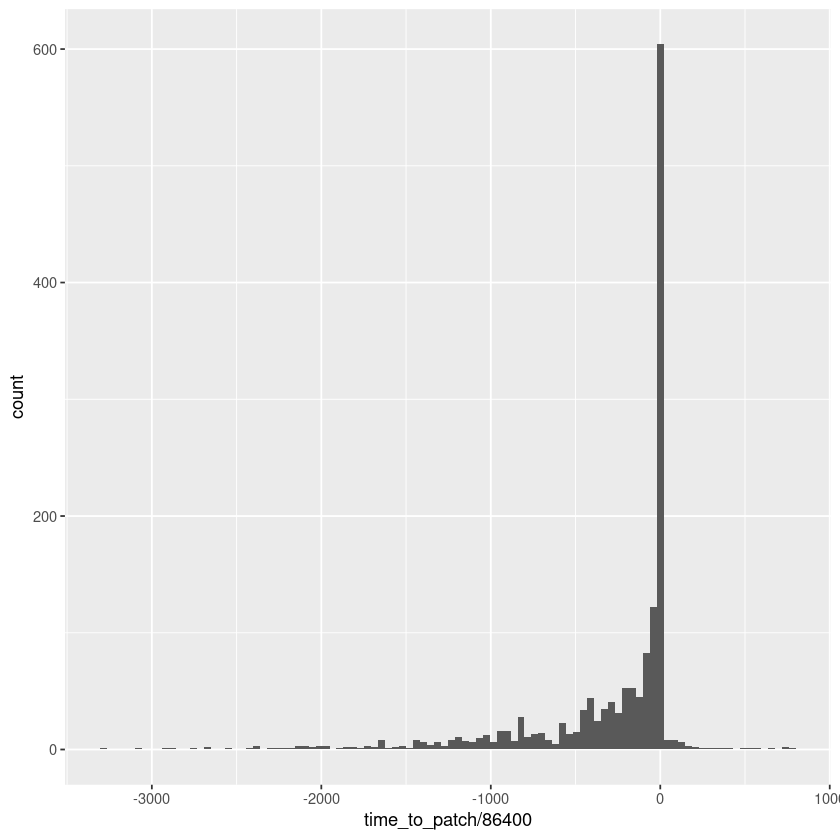

In [19]:
# Create a histogram of the time_to_patch values
# Convert to days, 86400 seconds in a day
ggplot(all_patches, aes(x = time_to_patch / 86400)) + 
    geom_histogram(bins = 100)

## How many patches occurr after the vulnerability is published?

In [27]:
100 * mean(all_patches$time_to_patch > 0)

[1] 4.407895